<a href="https://www.kaggle.com/code/yanpapadakis/timeseriesforecasting?scriptVersionId=137073767" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Multivariate Time Series Forecasting

Using LSTM Neural Networks in PyTorch and Multiple GPUs

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [2]:
if torch.cuda.is_available():
    dev = ["cuda:{}".format(i) for i in range(torch.cuda.device_count())]
else:
    dev = ["cpu"]

# Generate Simulated Data

In [3]:
lookback = 10
mem_length = 6
n = 10000
use_features = [0,1,2]
n_features = len(use_features)
pred_features = [0,2]
n_dim = len(pred_features)
train_split_ratio = 0.70

In [4]:
np.random.seed(2021)
timeseries = np.random.normal((-0.01,0.0),size=(n,n_features-1)).cumsum(0).astype('float32')
tmp = timeseries.prod(1).reshape(-1,1)
tmp = np.sqrt(tmp - tmp.min())
timeseries = np.hstack((timeseries, tmp - tmp[0]))
mem = np.zeros(n)
mem[0] = 5.0
mem[np.random.choice(n-1, size=n//100)+1] = 5.0
for i in range(n-mem_length):
    mem[i+mem_length] += 0.9 * mem[i]
timeseries[:,0] += mem
ts_length, n_features = timeseries.shape

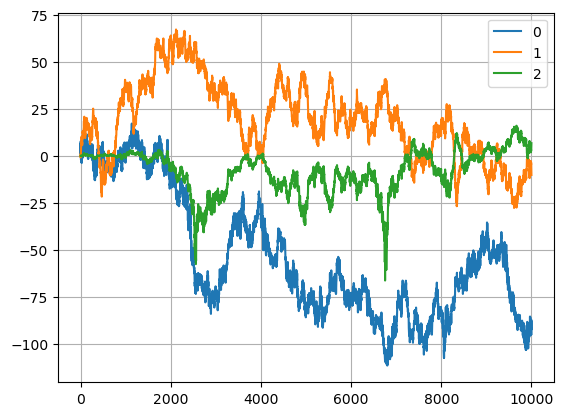

In [5]:
plt.plot(timeseries);
plt.legend(range(timeseries.shape[1]))
plt.grid();

# Build Time Series Model

Normalize Data

In [6]:
# train-test split for time series
train_size = int(ts_length * train_split_ratio)
test_size = ts_length - train_size
train = timeseries[:train_size,:]
test  = timeseries[train_size:,:]

In [7]:
scaler = MinMaxScaler()
scaler.fit(train);

In [8]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(lookback,len(dataset)):
        feature = dataset[i-lookback:i]
        target = dataset[i, pred_features]
        X.append(feature)
        y.append(target)
    return torch.FloatTensor(np.array(X)).to(dev[0]), torch.FloatTensor(np.array(y)).to(dev[0])

X_train, y_train = create_dataset(scaler.transform(train), lookback=lookback)
X_test, y_test   = create_dataset(scaler.transform(test), lookback=lookback)

In [9]:
class TSModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=hidden_size, batch_first=True)
        self.lstm = nn.DataParallel(self.lstm)
        self.linear = nn.Linear(hidden_size, n_dim)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.loss_fn = nn.SmoothL1Loss()
    def evaluate(self, X, y):
        with torch.no_grad():
            return self.loss_fn(self.__call__(X),y).item()
    def forward(self, x):
        # x dim: batch size X lookback size X n_features
        x, _ = self.lstm(x)
        # x dim: batch size X lookback size X hidden layer size
        x = self.linear(x)
        # x dim: batch size X lookback size X n_dim
        # Dim 0: Obs Index in Batch, Dim 1: Feature, Dim 2: Lookback Index
        x = self.pool(x.permute(0,2,1)) # Pool Lookbacks using 1d Pooling
        # x dim: batch size X n_dim X 1
        x = x.flatten(1) # Drop Last Dimension
        # x dim: batch size X n_dim
        return x

# Fit Model

In [10]:
hidden_size = 500
tsmod = TSModel(hidden_size).cuda()

optimizer = optim.Adam(
    tsmod.parameters(), 
    #lr=5e-4, 
    #weight_decay=1e-5
)

loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=128)

n_epochs = 500
best_rmse = 100.0
model_path = 'best_params.pt'
res_fmt = "Epoch {epoch:3d}:  Train RMSE {train_rmse:6.4f} / Test RMSE {test_rmse:6.4f}"
for epoch in range(n_epochs):
    # Training
    tsmod.train()
    for X_batch, y_batch in loader:
        y_pred = tsmod(X_batch)
        loss = tsmod.loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    tsmod.eval()
    test_rmse  = np.sqrt(tsmod.evaluate(X_test, y_test))
    train_rmse = np.sqrt(loss.item())
    if best_rmse > test_rmse:
        best_rmse = test_rmse
        chkpoint = {
            'epoch': epoch,
            'model_state_dict': tsmod.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_rmse': test_rmse,
            'train_rmse': train_rmse
        }
        torch.save(chkpoint, model_path)
    if epoch % 20 != 0:
        continue
    print(res_fmt.format(epoch=epoch, train_rmse=train_rmse, test_rmse=test_rmse))

Epoch   0:  Train RMSE 0.0508 / Test RMSE 0.1202
Epoch  20:  Train RMSE 0.0147 / Test RMSE 0.0201
Epoch  40:  Train RMSE 0.0172 / Test RMSE 0.0141
Epoch  60:  Train RMSE 0.0128 / Test RMSE 0.0134
Epoch  80:  Train RMSE 0.0126 / Test RMSE 0.0148
Epoch 100:  Train RMSE 0.0152 / Test RMSE 0.0128
Epoch 120:  Train RMSE 0.0133 / Test RMSE 0.0125
Epoch 140:  Train RMSE 0.0106 / Test RMSE 0.0117
Epoch 160:  Train RMSE 0.0104 / Test RMSE 0.0127
Epoch 180:  Train RMSE 0.0101 / Test RMSE 0.0119
Epoch 200:  Train RMSE 0.0115 / Test RMSE 0.0091
Epoch 220:  Train RMSE 0.0092 / Test RMSE 0.0109
Epoch 240:  Train RMSE 0.0092 / Test RMSE 0.0097
Epoch 260:  Train RMSE 0.0144 / Test RMSE 0.0092
Epoch 280:  Train RMSE 0.0092 / Test RMSE 0.0091
Epoch 300:  Train RMSE 0.0083 / Test RMSE 0.0082
Epoch 320:  Train RMSE 0.0079 / Test RMSE 0.0081
Epoch 340:  Train RMSE 0.0083 / Test RMSE 0.0078
Epoch 360:  Train RMSE 0.0081 / Test RMSE 0.0076
Epoch 380:  Train RMSE 0.0093 / Test RMSE 0.0109
Epoch 400:  Train RM

# Model Evaluation

In [11]:
checkpoint = torch.load(model_path)
tsmod = TSModel(hidden_size).cuda()
tsmod.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
tsmod.eval()
print("BEST Result:")
print("============")
print(res_fmt.format(**checkpoint))
print("Full X_train RMSE {:.4f}".format(
    np.sqrt(tsmod.evaluate(X_train, y_train)))
     )

BEST Result:
Epoch 427:  Train RMSE 0.0068 / Test RMSE 0.0074
Full X_train RMSE 0.0075


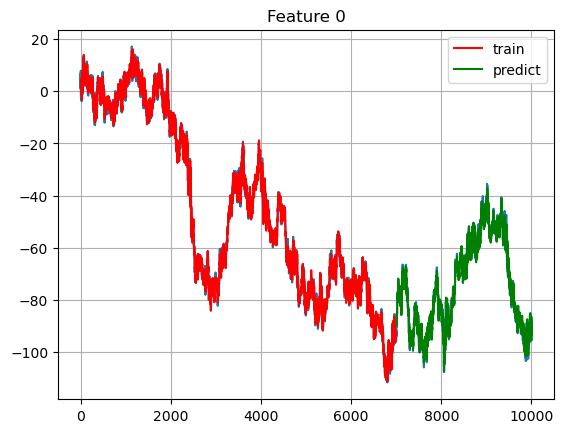

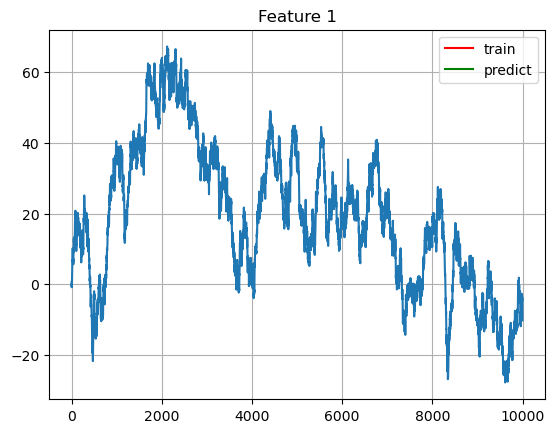

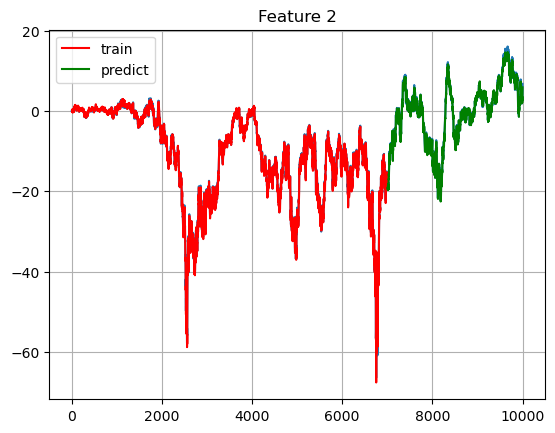

In [12]:
with torch.no_grad():
    
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    train_plot[lookback:train_size,pred_features] = tsmod(X_train).cpu()
    train_plot = scaler.inverse_transform(train_plot)
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries),pred_features] = tsmod(X_test).cpu()
    test_plot = scaler.inverse_transform(test_plot)
# plot
for i in range(n_features):
    plt.plot(timeseries[:,i])
    plt.plot(train_plot[:,i], c='r', label='train')
    plt.plot(test_plot[:,i], c='g', label='predict')
    plt.title("Feature {}".format(i))
    plt.legend()
    plt.grid()
    plt.show()

In [13]:
with torch.no_grad():
    input = X_test.cpu().numpy()
    output = tsmod(X_test).cpu().numpy()
    target = y_test.cpu().numpy()

input.shape, output.shape, target.shape

((2990, 10, 3), (2990, 2), (2990, 2))

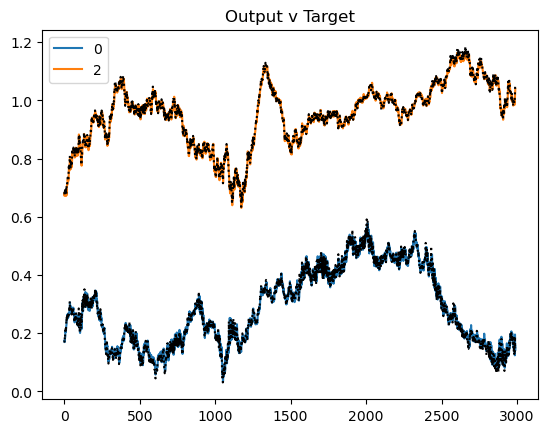

In [14]:
for d in range(n_dim):
    plt.plot(output[:,d], label=pred_features[d])
    plt.plot(target[:,d], 'k:')
    plt.legend()
plt.title("Output v Target")
plt.show()

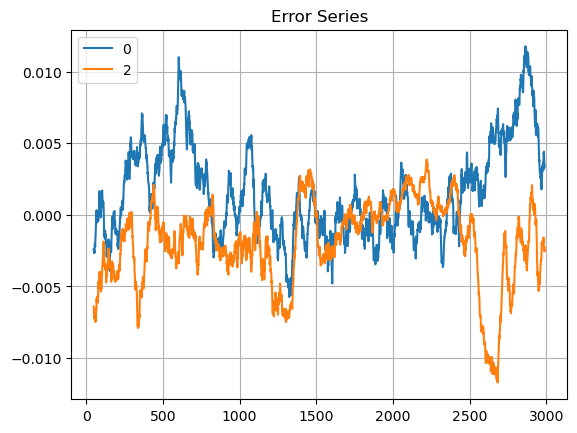

In [15]:
diff = pd.DataFrame(output - target, columns=pred_features)
diff.rolling(window=50).mean().plot(grid=True, title='Error Series');